<h1 style="color:black;">Classification Project: Newspaper Articles</h1>

<h3 style="color:blue;">PROJECT OVERVIEW</h3>

>The key goal of this classification project is for our team to develop machine learning models that can automatically classify newspaper articles. This project is an end-to-end project covering all stages, from loading and preprocessing data to training models, evaluating them, and deploying the solution as a web app using Streamlit.

<h3 style="color:blue;">IMPORTING PACKAGES</h3>

> This project will utilise the packages below to efficiently load, clean, analyse and visualise the newspaper article data. The packages are imported and necessary libraries are downloaded below:

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

from nltk.corpus import  stopwords
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

In [22]:
nltk.download(['punkt','punkt_tab','stopwords','wordnet'], quiet=True)

True

<h3 style="color:blue;">DATA LOADING</h3>

> When the required packages are imported, for loading a CSV file, this Project will utilise Pandas to load the data.

In [23]:
# Load training and testing datasets
train_df = pd.read_csv("https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/train.csv", encoding="utf-8")
test_df = pd.read_csv("https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/test.csv", encoding="utf-8")


In [24]:
# Display first few rows of the Dataframes as tables
display(train_df.head(2))
display(test_df.head(2))


,headlines,description,content,url,category
0,RBI revises definition of politically-exposed ...,The central bank has also asked chairpersons a...,The Reserve Bank of India (RBI) has changed th...,https://indianexpress.com/article/business/ban...,business
1,NDTV Q2 net profit falls 57.4% to Rs 5.55 cror...,NDTV's consolidated revenue from operations wa...,Broadcaster New Delhi Television Ltd on Monday...,https://indianexpress.com/article/business/com...,business


,headlines,description,content,url,category
0,NLC India wins contract for power supply to Ra...,State-owned firm NLC India Ltd (NLCIL) on Mond...,State-owned firm NLC India Ltd (NLCIL) on Mond...,https://indianexpress.com/article/business/com...,business
1,SBI Clerk prelims exams dates announced; admit...,SBI Clerk Prelims Exam: The SBI Clerk prelims ...,SBI Clerk Prelims Exam: The State Bank of Indi...,https://indianexpress.com/article/education/sb...,education


<h3 style="color:blue;">DATA CLEANING AND TEXT PREPROCESSING</h3>


> Text cleaning is essential for improving model accuracy. We'll look into standardizing text by converting everything to lowercase, removing punctuation and special characters, splitting text into individual words for further processing and removing common words that don't add much meaning.

Let's start by printing a list of all categories that are present in this dataset

In [25]:
# Print list of unique newspaper categories
category_labels = list(train_df.category.unique())
print(category_labels)

['business', 'sports', 'entertainment', 'education', 'technology']


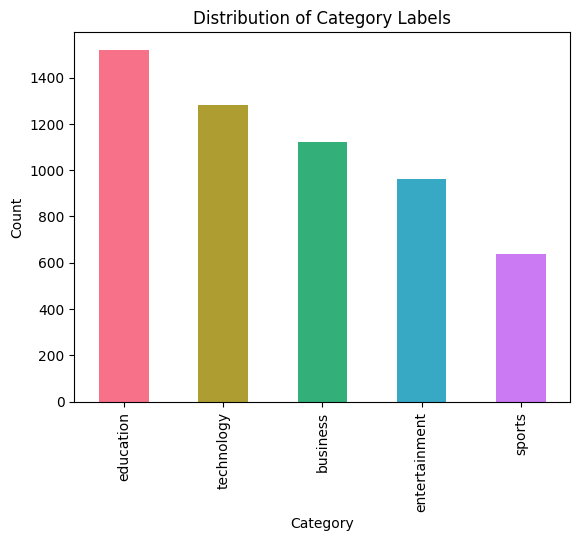

In [26]:
# Define a color palette
colors = sns.color_palette('husl', len(train_df['category'].value_counts()))

# Visualize the distribution of the categories with colored bars
train_df['category'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Category Labels')
plt.show()


In [27]:
# Shape of the dataset
train_df.shape
test_df.shape

(2000, 5)

In [28]:
# Check for missing values
print("Missing values in dataset:\n", train_df.isnull().sum())
print("Missing values in dataset:\n", test_df.isnull().sum())

Missing values in dataset:
 headlines      0
description    0
content        0
url            0
category       0
dtype: int64
Missing values in dataset:
 headlines      0
description    0
content        0
url            0
category       0
dtype: int64


There was no need to handle missing values as there were none

In [29]:
# Check and remove duplicates
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

if train_df.duplicated().any():
    print("Duplicates are present in the dataset.")
else:
    print("No duplicates found in the dataset.")

if test_df.duplicated().any():
    print("Duplicates are present in the dataset.")

No duplicates found in the dataset.


In [30]:
# Define a function to preprocess text data
def format_data (text):
    text = re.sub(r'http\S+|www\S+|https\S+', 'url-web', text, flags=re.MULTILINE)
    text = text.lower()
    pun_nums = string.punctuation + "0123456789"
    stop_words = set(stopwords.words('english'))
    set_to_remove = stop_words.union(set(pun_nums))
    word_tokens = word_tokenize(text)

    filterd_text = " ".join([w for w in word_tokens if w not in set_to_remove])

    second_check = re.sub(r'\d','',filterd_text)

    return second_check

In [31]:
# Apply the function to each column in the training dataset
train_df["headlines"] = train_df["headlines"].apply(format_data)
train_df["description"] = train_df["description"].apply(format_data)
train_df["content"] = train_df["content"].apply(format_data)

# Preview the preprocessed data
print(train_df[["headlines", "description", "content"]].head())

                                           headlines  \
0  rbi revises definition politically-exposed per...   
1  ndtv q net profit falls . rs . crore impacted ...   
2  akasa air ‘ well capitalised ’ grow much faste...   
3  india ’ current account deficit declines sharp...   
4   states borrowing cost soars . highest far fiscal   

                                         description  \
0  central bank also asked chairpersons chief exe...   
1  ndtv 's consolidated revenue operations rs . c...   
2  initial share sale open public subscription ju...   
3  current account deficit cad . per cent gdp usd...   
4  prices shot reflecting overall higher risk ave...   

                                             content  
0  reserve bank india rbi changed definition poli...  
1  broadcaster new delhi television ltd monday re...  
2  homegrown server maker netweb technologies ind...  
3  india ’ current account deficit declined sharp...  
4  states forced pay nose weekly auction debt tue..

<h3 style="color:blue;">FEATURE ENGENEERING</h3>

In [32]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer

# Format feature variables
X_train = np.array(train_df['headlines'] + ' ' + train_df['description'] + ' ' + train_df['content'])
X_test = np.array(test_df['headlines'] + ' ' + test_df['description'] + ' ' + test_df['content'])

# Format target variables
y_train = train_df['category']
y_test = test_df['category']

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (5520,)
y_train shape: (5520,)
X_test shape: (2000,)
y_test shape: (2000,)


In [33]:
# Defining a function to vectorize data
def vectorize_data(X_train, X_test):
    # Initialize CountVectorizer with stop_words handling and minimum document frequency
    vect = CountVectorizer(stop_words='english', min_df=0.01)
    X_train = vect.fit_transform(X_train).toarray()  # Transform and convert to NumPy array
    X_test = vect.transform(X_test).toarray()
    joblib.dump(vect, 'vectorizer/vectorizer.pkl')

    return X_train, X_test

In [34]:
# Apply vectorization to each column
X_train, X_test = vectorize_data(X_train, X_test)


In [35]:
# Print results
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5520, 1792)
X_test shape: (2000, 1792)


<h3 style="color:blue;">TRAINING MODELS</h3>

In [36]:
# !pip install mlflow when MLflow is not installed
# Set the tracking URI for MLflow
import mlflow


In [37]:
mlflow.set_experiment("News Category Classification")

<Experiment: artifact_location='file:///c:/Users/kelly/Downloads/mlruns/120195847260961004', creation_time=1746638902146, experiment_id='120195847260961004', last_update_time=1746638902146, lifecycle_stage='active', name='News Category Classification', tags={}>

In [38]:
# Import necessary libraries for model training
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix


In [39]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Classifier': SVC(kernel='linear', random_state=42),
    'Naive Bayes': MultinomialNB()
}
# Initialize a dictionary to store the results
results = {}


<h3 style="color:blue;">TRAINING AND EVALUATING MODELS INSIDE MLFLOW</h3>

In [40]:
# End any active MLflow run
mlflow.end_run()

# Train and evaluate each model inside MLflow tracking
accuracy_results = {}
cm_results = {}

for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name, nested=True):  # Only use nested runs
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the validation set
        y_pred = model.predict(X_test)

        # Calculate accuracy and store results
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        accuracy_results[model_name] = {'accuracy':accuracy}
        cm_results[model_name] = {'confusion_matrix':cm}

        # Log the model and metrics to MLflow
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("accuracy",  precision_score(y_test, y_pred, average='weighted'))
        mlflow.log_metric("accuracy",  f1_score(y_test, y_pred, average='weighted'))
        mlflow.log_metric("accuracy",  recall_score(y_test, y_pred, average='weighted'))

        # Print classification report and confusion matrix
        print(f"Model: {model_name}")
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Accuracy:", accuracy)
        print("-" * 50)

Model: Logistic Regression
Classification Report:
                precision    recall  f1-score   support

     business       0.97      0.95      0.96       400
    education       0.98      0.98      0.98       400
entertainment       0.99      0.98      0.99       400
       sports       0.98      0.98      0.98       400
   technology       0.93      0.96      0.95       400

     accuracy                           0.97      2000
    macro avg       0.97      0.97      0.97      2000
 weighted avg       0.97      0.97      0.97      2000

Accuracy: 0.9725
--------------------------------------------------
Model: Random Forest
Classification Report:
                precision    recall  f1-score   support

     business       0.96      0.95      0.95       400
    education       0.98      0.99      0.98       400
entertainment       0.99      0.95      0.97       400
       sports       0.98      0.96      0.97       400
   technology       0.90      0.95      0.92       400

     a

<h3 style="color:blue;">SELECTING THE BEST MODEL</h3>

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'Support Vector Classifier': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Naive Bayes': {}  
}

# Perform Grid Search for each model
best_estimators = {}
best_scores = {}

for model_name, params in param_grids.items():
    model = models[model_name]
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_estimators[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

# Select the best model based on Grid Search results
best_model = max(best_scores, key=best_scores.get)
best_model_instance = best_estimators[best_model]

print(f"Best Model from GridSearch: {best_model}")

# End run if already running
mlflow.end_run()

# Save the best model to MLflow
with mlflow.start_run():
    mlflow.sklearn.log_model(best_model_instance, "Best_model", input_example=X_train[:1])

# Make predictions on the test set
y_test_pred = best_model_instance.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
mlflow.log_metric("test_accuracy", accuracy_test)
report_test = classification_report(y_test, y_test_pred)

# Print the test set results
print("Best model performance on test set:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", report_test)

In [ ]:
# Save each trained model
for model_name, model in models.items():
    joblib.dump(model, f"models/{model_name.replace(' ', '_')}.pkl")  # Replacing spaces with underscores in filenames
    print(f"Saved {model_name} model successfully!")

Saved Logistic Regression model successfully!
Saved Random Forest model successfully!
Saved Support Vector Classifier model successfully!
Saved Naive Bayes model successfully!


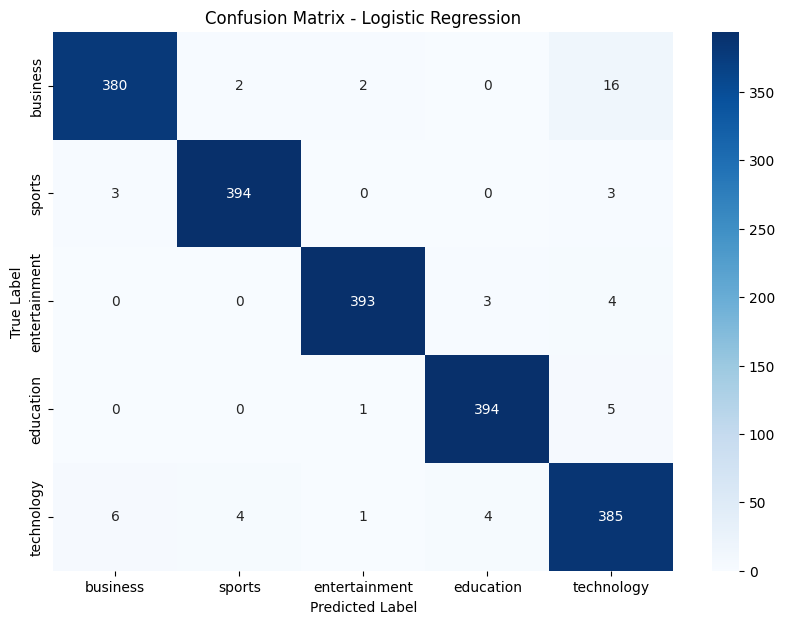

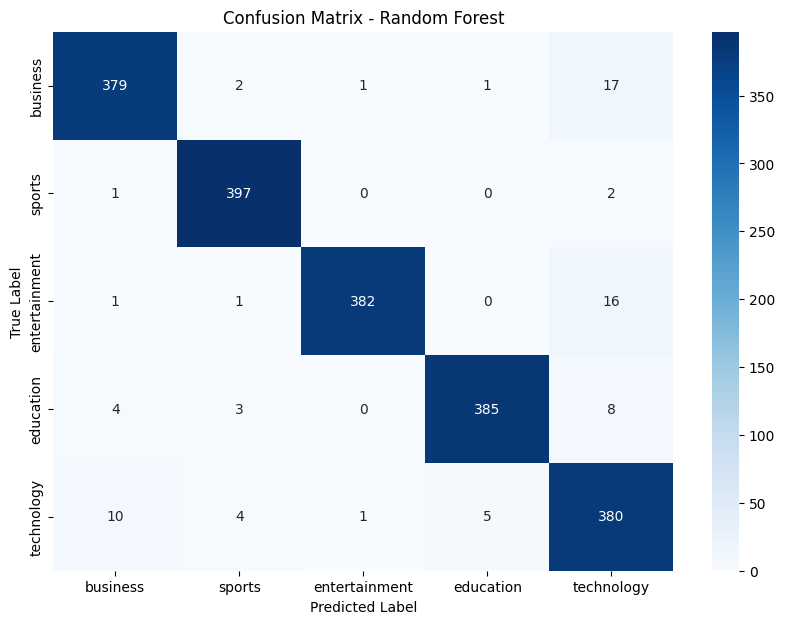

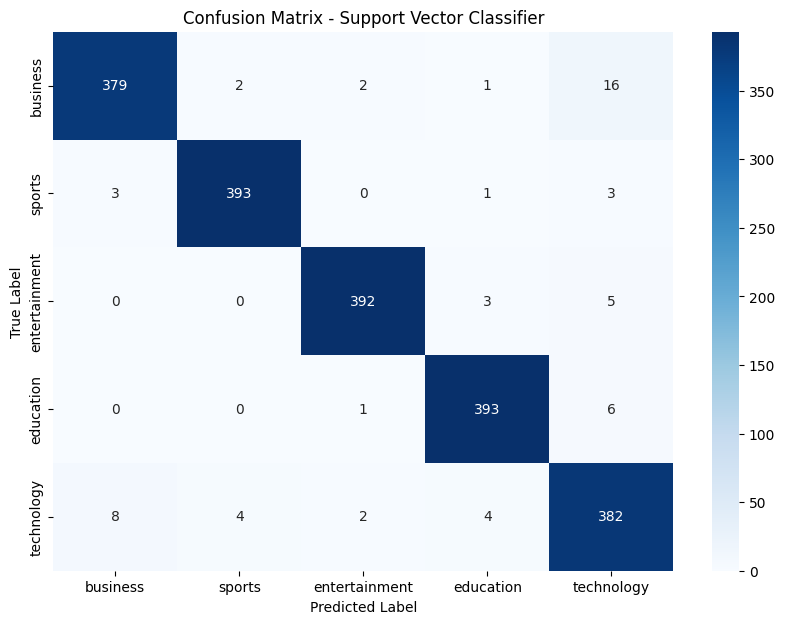

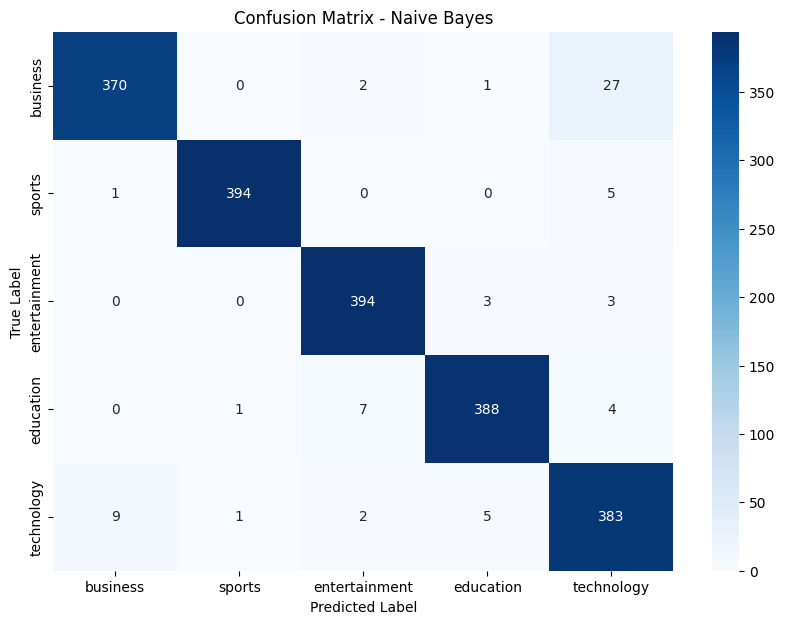

In [ ]:
def plot_confusion_matrix(cm, model_name, labels):
    """Plots the confusion matrix using Seaborn."""
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get the unique category labels
category_labels = list(train_df.category.unique())

# Plot the confusion matrix for each model
for model_name, data in cm_results.items():
    cm = data['confusion_matrix']
    plot_confusion_matrix(cm, model_name, category_labels)

This confusion matrix visually represents the performance of a classification model in categorizing various topics: business, sports, entertainment, education, and technology. The diagonal values show correct classifications, with Education having the greater correctly classified number and only 4 samples being incorrectly classified( one classified as business and 3 classified as technology)

**solutions to misclassifications:**
Our confusion matrix visualization suggest there is a confusion between certain categories, which may require better feature engineering or tuning of the model.

In [ ]:
# Run MLflow UI to view the experiment results
!mlflow ui

[2025-05-11 10:27:37 +0000] [27092] [INFO] Starting gunicorn 23.0.0
[2025-05-11 10:27:37 +0000] [27092] [INFO] Listening at: http://127.0.0.1:5000 (27092)
[2025-05-11 10:27:37 +0000] [27092] [INFO] Using worker: sync
[2025-05-11 10:27:37 +0000] [27093] [INFO] Booting worker with pid: 27093
[2025-05-11 10:27:37 +0000] [27094] [INFO] Booting worker with pid: 27094
[2025-05-11 10:27:37 +0000] [27095] [INFO] Booting worker with pid: 27095
[2025-05-11 10:27:37 +0000] [27096] [INFO] Booting worker with pid: 27096
[2025-05-11 10:30:39 +0000] [27092] [INFO] Handling signal: int
^C

Aborted!
[2025-05-11 10:30:39 +0000] [27093] [INFO] Worker exiting (pid: 27093)
[2025-05-11 10:30:39 +0000] [27094] [INFO] Worker exiting (pid: 27094)
[2025-05-11 10:30:39 +0000] [27096] [INFO] Worker exiting (pid: 27096)


<h3 style="color:blue;">CONCLUSION AND INSIGHTS</h3>

> To conclude, our team built a comprehensive news categorization pipeline, from preprocessing text to training multiple models and evaluating performance using MLflow. The key steps that were taken were:

**1.** Data Preparation – Combined vectorized text features & split into training, validation, and test sets.

**2.** Model Training & Evaluation – Trained Logistic Regression, Random Forest, Naïve Bayes, and SVM, logging accuracy & metrics in MLflow.

**3.** Best Model Selection – Identified the best-performing model dynamically based on validation accuracy.

**4.** Model Deployment – Saved the best model and vectorizer for future predictions using joblib.

**5.** Results Tracking – MLflow logged parameters, accuracy, and confusion matrices, allowing comparison between models.

**6.** Created a Prediction Function – Built a reusable function to classify new articles dynamically.

**Results from MLflow:**
The "Test Accuracy" showed that the best-performing model wasthe Logistic Regression model
, which achieved strong accuracy, with performance tracked across all trained models.
